<img src='../images/copernicus_eumetsat_logo.jpg' alt='Copernicus EUMETSAT' align='right' width='50%'></img>

# Global Air Quality Index
In this notebook we'll compute the forecasts of the global air quality index (AQI). The computation of the AQI forecast is based on the forecast concentration of some pollutants: $O_3, NO_2, SO_2, PM2.5, PM10$, and is done according to the [European Air Quality Index](https://en.wikipedia.org/wiki/Air_quality_index#Europe) definition. The concentration of the pollutants will be time averaged and transformed in $\mu g \cdot m^{-3}$ and finally classified in one of six levels, from *Very good* to *Extremly poor*, according to the threshold levels defined in the European Air Quality Index. The air quality index is the highest value of the concentration levels of the pollutants. For instance, if the concentration level for all the pollutants but $O_3$ is *Very good* but for $O_3$ is *Medium*, then the air quality index is *Medium*.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcol
from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap
from zipfile import ZipFile
import cdsapi
import warnings
warnings.filterwarnings('ignore')

## The CAMS CDS API
We use the [CAMS global atmospheric composition forecasts](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-atmospheric-composition-forecasts) dataset. The spatial resolution is lower than that available for the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) used in previous edition of the training event but it covers the whole planet. The dataset is available from the Copernicus Atmosphere Monitoring Service (CAMS) web service. The spatial grid is 0.4° x 0.4° so that each cell has size 44 km x 44 km, approximately.  In order to compute the air quality index we will download the data of the pollutants and the meteorological data: surface pressure, and 2m air temperature. The trace gases are provided for 137 vertical levels and are available at 3-hourly intervals. We will download the trace gases data only for surface level, that is level 137. The particulate matter and the meteorological data are available at single level at hourly intervals.

* Ozone mass mixing ratio [kg kg**-1]
* Sulphur dioxide mass mixing ratio [kg kg**-1]
* Nitrogen dioxide mass mixing ratio [kg kg**-1]
* Particulate matter d <= 2.5 um [kg m**-3]
* Particulate matter d <= 10 um [kg m**-3]

* Surface pressure [Pa]
* Air temperature [K]

The concentration of the trace gases is given using a dimensionless unit. Since we want to use a common unit for all the pollutants we will have to transform the trace gases data from a dimensionless unit to mass concentration. We will use the surface pressure and the air temperature to perform such transformation. We use the forecast data for two days, starting at 00:00

In [2]:
start_date = '2024-08-24'
end_date = '2024-08-24'
init_hour = '00'
lead_time_start = 0
lead_time_stop = 25
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))
leadtime_hours;

In [3]:
variables = ['2m_temperature',
            'surface_pressure', 
            'particulate_matter_2.5um',
            'particulate_matter_10um',
            'nitrogen_dioxide', 
            'ozone',
            'sulphur_dioxide']
bb_north = 90
bb_south = -90
bb_west = -180
bb_east = 180
area = [bb_north, bb_west, bb_south, bb_east]  

In [4]:
DATADIR = 'data'
WDIR = f'cams_fc_eaqi_{start_date}_{end_date}_{init_hour}'

In [5]:
dataset = 'cams-global-atmospheric-composition-forecasts'

In [6]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{init_hour}:00',
        'leadtime_hour': leadtime_hours,
        'model_level': '137',
        'type': 'forecast',
        'area': area,
        'format': 'netcdf_zip',
    }

In [21]:
c = cdsapi.Client()
c.retrieve(
    dataset,
    request,
    f'{DATADIR}/{WDIR}.zip')

2024-08-24 16:31:02,295 INFO Welcome to the CDS
2024-08-24 16:31:02,297 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-08-24 16:31:02,384 INFO Request is completed
2024-08-24 16:31:02,387 INFO Downloading https://download-0004-ads-clone.copernicus-climate.eu/cache-compute-0004/cache/data7/adaptor.mars_constrained.internal-1724509526.8187182-4956-11-1c1be272-9a0e-47c6-885f-99f87e3aa3fa.zip to data/cams_fc_eaqi_2024-08-24_2024-08-24_00.zip (98.3M)
2024-08-24 16:31:11,100 INFO Download rate 11.3M/s  


Result(content_length=103113700,content_type=application/zip,location=https://download-0004-ads-clone.copernicus-climate.eu/cache-compute-0004/cache/data7/adaptor.mars_constrained.internal-1724509526.8187182-4956-11-1c1be272-9a0e-47c6-885f-99f87e3aa3fa.zip)

We open the zip file and extract the data into a folder. Trace gases concentration and temperature data are in the multi-level variable set levtype_ml.nc, particulate matter and surface pressure data are in single level variables set levtype_sfc.nc.

In [24]:
with ZipFile(f'{DATADIR}/{WDIR}.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/{WDIR}/')

## Aerosols and meteorological data
The concentration of aerosol PM2.5 and PM10 are provided as densities in $kg \cdot m^{-3}$ 

In [7]:
single_level_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_sfc.nc') 
single_level_ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 25)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-24 ... 2024-08-25
Data variables:
    sp         (time, latitude, longitude) float32 ...
    pm2p5      (time, latitude, longitude) float32 ...
    pm10       (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-24 14:25:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Trace gases
The concentration of the trace gases is provided as mixing ratio, a dimensionless quantity that represents the ratio between the mass concentration of the trace gas, in kg per unit volume, and the mass concentration of air.  

In [8]:
multi_level_ds = xr.open_dataset(f'{DATADIR}/{WDIR}/levtype_ml.nc') 
multi_level_ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 9)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-08-24 ... 2024-08-25
Data variables:
    go3        (time, latitude, longitude) float32 ...
    so2        (time, latitude, longitude) float32 ...
    no2        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-24 14:25:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Scaling factor
We calculate the scaling factor, to convert the dimensionless mixing ratios of $NO_2, SO_2$, and $O_3$ from kg/kg to mass density in ug/m3, using the air surface pressure, the temperature. We start from the definition of mass mixing ratio of a chemical species X in air

$$\alpha_x = \frac{\rho_x}{\rho}$$

where $\rho_x$ is the mass density of the chemical species X in $kgm^{-3}$ and $\rho$ is the mass density of the air. We assume the trace gases and the dry air to follow the ideal gas law so that for dry air we can write

$$pV = nRT$$

where p is the air pressure, $R = K_B N_A = 8.314 \text{ } JK^{-1}mol^{-1}$ is the ideal gas constant, where $K_B$ is the Boltzmann constant and $N_A$ is the Avogadro's number, V the volume, T the temperature, and finally n is the number of moles. The number of moles is defined as the ratio of the mass and the molar mass. For dry air, a mixture of several gases, the molar mass $M_a$ can be represented by the weighted sum of the molar masses of all the chemical species in the air (see Jacob, chap.1, p.4)

$$M_a = \sum_i w_iM_i = 28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}$$

With this defnition the number of moles of dry air can be written as

$$n = \frac{m}{M_a}$$
 
where m is the mass of the dry air. Substituting this definition into the gas law for dry air we have

$$pV = \frac{m}{M_a}RT$$

We can define the gas constant of dry air from the ideal gas constant R and the molar mass of dry air

$$R_a = \frac{R}{M_a} = \frac{8.314 \text{ } JK^{-1}mol^{-1}}{28.96 \cdot 10^{-3} \text{ } kg\text{ }mol^{-1}} = 287.08 \text{ } JK^{-1}kg^{-1}$$

We can now write the law for dry air as

$$pV = mR_aT$$

and

$$p = \frac{m}{V}R_aT = \rho R_aT$$

so that the mass density of dry air is

$$\rho = \frac{p}{R_aT}$$

from which we can write the equation of the mass density of a chemical species in the air as a function of its mixing ratio, the air pressure and temperature, and given the air specific gas constant

$$\rho_x = \alpha_x \frac{p}{R_aT} \text{ } kg m^{-3}$$

If we define the factor c as

$$c = \frac{p}{R_aT}$$

we can transform the mixing ratio of a chemical species to mass density using the equation

$$\rho_x = c \alpha_x$$

We calculate the scaling factor

In [9]:
R = 287.08
cfactor = single_level_ds['sp'] / (R * single_level_ds['t2m'])

With the scaling factor we can transform the concentration values of the trace gases into $kg \cdot m^{-3}$. Then, we multiply for $10^9$ to represent the values in $\mu g \cdot m^{-3}$

In [10]:
trace_gases = ['no2','go3','so2']
for gas in trace_gases:
    multi_level_ds[gas] = multi_level_ds[gas] * cfactor * 1e9

In [11]:
particulate_matter = ['pm2p5','pm10']
for param in particulate_matter:
    single_level_ds[param] = single_level_ds[param] * 1e9

## 24h max and mean average
We aggregate the data by computing the maximun daily values of the trace gases concentration and mean daily values of the particulate matter concentration.

In [216]:
multi_level_max = multi_level_ds.resample(time='1D').max()
multi_level_max = multi_level_max.squeeze(drop=True)

In [193]:
single_level_mean = single_level_ds.resample(time='1D').mean()
single_level_mean = single_level_mean.squeeze(drop=True)

We merge the trace gases and the particulate matter into one array

In [218]:
eaqi_daily = xr.merge([single_level_mean, multi_level_max])

In [219]:
eaqi_daily = eaqi_daily.drop_vars(["t2m", "sp"])

## Exploratory data analysis and outliers detection
Before visualization we perfom a simple data analysis, mostly to assess whether there are outliers in the dataset, that is values that are far from the bulk of the data. This step is useful in general and in particular when we want to plot the data since outliers have a strong impact on visualization. We calculate for each variable 7 descriptive statistical parameters: min, lower quartile, median, upper quartile, max, interquartile range, and skewness. If we observe a large maximum value compared with the upper quartile it is likely that the dataset contains outliers, that is values that are far from the bulk of the data and might not come from real observations.

In [220]:
def summary_statistics(xr_da):
    """
    This function returns a list of 5 descriptive statistical
    parameters of an xarray DataArray:
    min, lower quartile, median, upper quartile, max.
    """
    da_min = xr_da.min()
    da_lq = xr_da.quantile(.25)
    da_median = xr_da.median()
    da_uq = xr_da.quantile(.75)
    da_max = xr_da.max()
    iqr = da_uq - da_lq
    skew = (da_lq -2 * da_median + da_uq) / iqr
    return [da_min, da_lq, da_median, da_uq, da_max, iqr, skew]

In [221]:
def print_statistics(variable_name, statistics):
        min = statistics[0] 
        lq = statistics[1]
        median = statistics[2]
        uq = statistics[3]
        max= statistics[4]
        iqr = statistics[5]
        skew = statistics[6]
        print(variable_name + ' concentration (micrograms/m^3)\n' \
            'Min.: {:.2f}\n' \
            'Lower quartile: {:.2f}\n' \
            'Median.: {:.2f}\n' \
            'Upper quartile: {:.2f}\n' \
            'Max: {:.2f}\n' \
            'IQR: {:.2f}\n' \
            'Skew: {:.2f}\n'.format(min, 
                                 lq, 
                                 median,
                                 uq,
                                 max,
                                 iqr,
                                 skew))

In [222]:
def contour_quantiles(xr_da):
    """
    This function can be used to calculate the contour levels
    for plotting. 
    """
    quantiles = [0.0]
    #partition_values = np.arange(start=0.1, stop=1.1, step=0.1)
    partition_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
    last_quantile = 0.0
    for i in range(len(partition_values)):
        value = partition_values[i]
        quantile = round(xr_da.quantile(value).item(), 2)
        if (quantile - last_quantile > 0.0):
            quantiles.append(quantile)
            last_quantile = quantile
    return quantiles

Now we use the functions defined above to calculate a summary statistics of the variables

In [223]:
variable_name = 'no2'
no2_da = eaqi_daily['no2']
#no2_masked_da = no2_da.where(no2_da >= 0.0)

In [224]:
statistics = summary_statistics(no2_da)
print_statistics(variable_name, statistics)

no2 concentration (micrograms/m^3)
Min.: 0.00
Lower quartile: 0.01
Median.: 0.03
Upper quartile: 0.23
Max: 188.33
IQR: 0.23
Skew: 0.76



In [225]:
no2_levels = contour_quantiles(no2_da)
no2_levels

[0.0, 0.01, 0.02, 0.03, 0.06, 0.14, 0.39, 1.45, 10.92, 35.98]

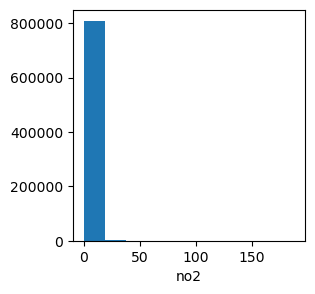

In [226]:
h_plot = no2_da.plot.hist(figsize=(3,3))

In [227]:
variable_name = 'go3'
o3_da = eaqi_daily['go3']
#o3_masked_da = o3_da.where(o3_da >= 0.0)
statistics = summary_statistics(o3_da)
print_statistics(variable_name, statistics)

go3 concentration (micrograms/m^3)
Min.: 1.38
Lower quartile: 51.84
Median.: 63.55
Upper quartile: 71.25
Max: 533.89
IQR: 19.40
Skew: -0.21



In [228]:
o3_levels = contour_quantiles(o3_da)
o3_levels

[0.0,
 37.72,
 47.46,
 55.01,
 59.54,
 63.55,
 66.98,
 69.8,
 72.88,
 78.58,
 121.65,
 195.2]

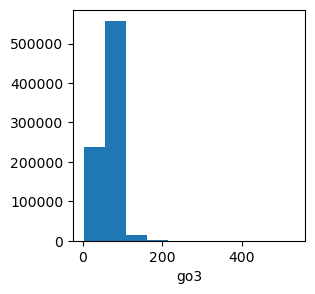

In [229]:
h_plot = o3_da.plot.hist(figsize=(3,3))

In [230]:
variable_name = 'so2'
so2_da = eaqi_daily['so2']
#so2_masked_da = so2_da.where(so2_da >= 0.0)
statistics = summary_statistics(so2_da)
print_statistics(variable_name, statistics)

so2 concentration (micrograms/m^3)
Min.: 0.00
Lower quartile: 0.02
Median.: 0.10
Upper quartile: 0.25
Max: 1247.74
IQR: 0.23
Skew: 0.30



In [231]:
so2_levels = contour_quantiles(so2_da)
so2_levels

[0.0, 0.02, 0.06, 0.1, 0.15, 0.21, 0.32, 0.74, 7.08, 34.04]

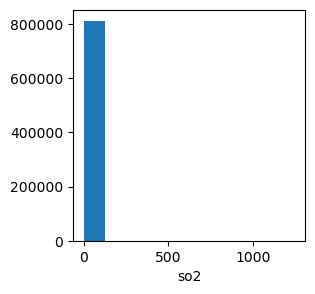

In [232]:
h_plot = so2_da.plot.hist(figsize=(3,3))

In [233]:
variable_name = 'pm2p5'
pm25_da = eaqi_daily['pm2p5']
#pm25_masked_da = pm25_da.where(pm25_da >= 0.0)
statistics = summary_statistics(pm25_da)
print_statistics(variable_name, statistics)

pm2p5 concentration (micrograms/m^3)
Min.: 0.00
Lower quartile: 3.97
Median.: 10.43
Upper quartile: 16.20
Max: 438.45
IQR: 12.22
Skew: -0.06



In [234]:
pm25_levels = contour_quantiles(pm25_da)
pm25_levels

[0.0, 0.1, 2.37, 5.37, 7.83, 10.43, 12.89, 15.1, 17.41, 21.09, 40.9, 96.2]

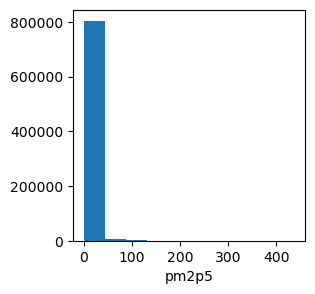

In [235]:
h_plot = pm25_da.plot.hist(figsize=(3,3))

In [236]:
variable_name = 'pm10'
pm10_da = eaqi_daily['pm10']
#pm10_masked_da = pm10_da.where(pm10_da >= 0.0)
statistics = summary_statistics(pm10_da)
print_statistics(variable_name, statistics)

pm10 concentration (micrograms/m^3)
Min.: -0.00
Lower quartile: 6.73
Median.: 19.35
Upper quartile: 31.63
Max: 3910.23
IQR: 24.90
Skew: -0.01



In [237]:
pm10_levels = contour_quantiles(pm10_da)
pm10_levels

[0.0,
 0.16,
 3.93,
 9.23,
 13.99,
 19.35,
 24.77,
 29.41,
 34.06,
 41.72,
 130.54,
 576.86]

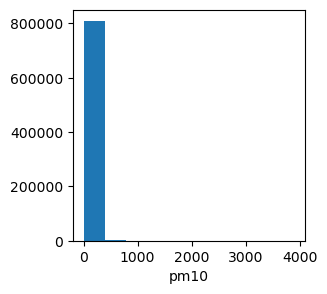

In [238]:
h_plot = pm10_da.plot.hist(figsize=(3,3))

In [239]:
params = ['no2','go3','so2','pm2p5','pm10']
all_levels = [no2_levels, o3_levels, so2_levels, pm25_levels, pm10_levels]

## Plotting the global concentrations of trace gases and particulate matter
From the shape of the dataset (height and width) and the spatial resolution we should be able to calculate the global area that should be equal top the Earth surface. 

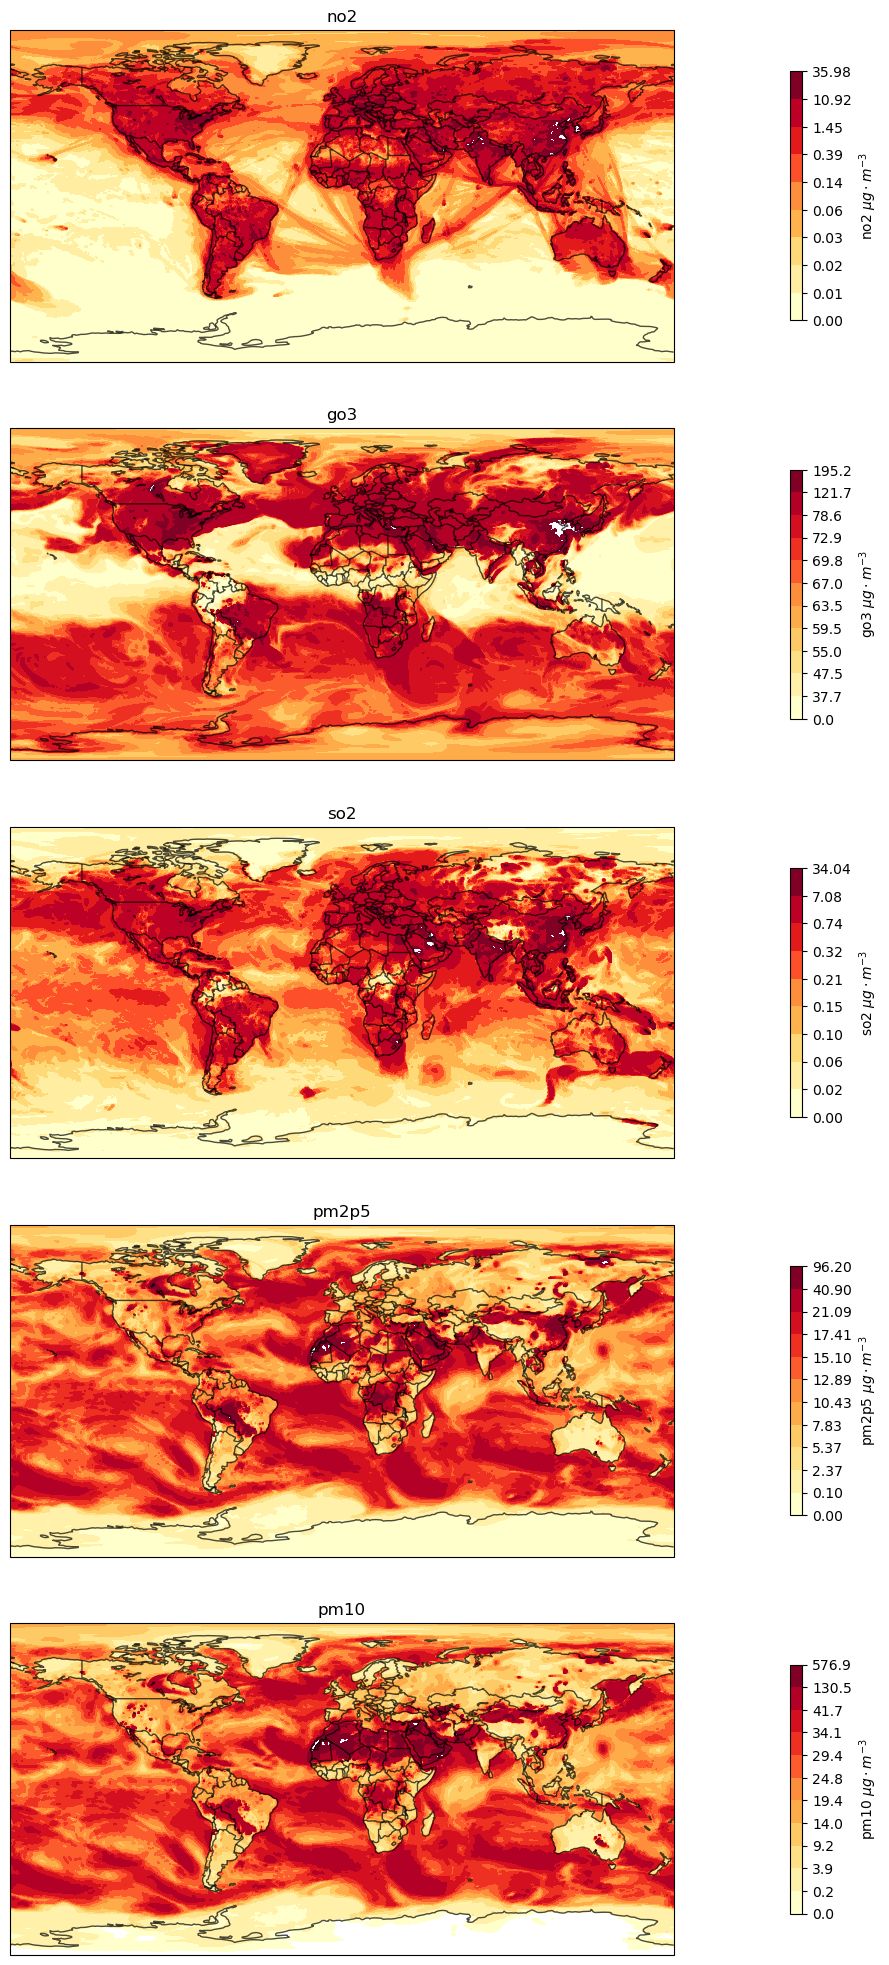

In [240]:
fig, axs = plt.subplots(nrows=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(30, 25))

for i, param in enumerate(params):
    da = eaqi_daily[param]
    clevs = all_levels[i]
    day_index = 0
    data = da[day_index,:,:]
    #vmin = da.min()
    #vmax = da.max() 
    cs = axs[i].contourf(da.longitude, da.latitude, data, 
                        levels = clevs, 
                        #vmin=0.0, 
                        #vmax=vmax,
                        cmap='YlOrRd', # 'RdYlBu_r', 
                        norm = mcol.BoundaryNorm(clevs, 256), 
                        transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75, ticks=clevs)
    cbar.set_label(param + ' $\mu g \cdot m^{-3}$')
    #axs[i].set_yticklabels(clevs)
    axs[i].set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree()) 
    axs[i].set_title(param)
    axs[i].coastlines(color='black', alpha=0.7) 
    axs[i].add_feature(cfeature.LAKES, alpha=0.7, edgecolor='black', facecolor='none')
    axs[i].add_feature(cfeature.BORDERS, alpha=0.7)
    axs[i].margins(0.5)

## Calculating the air quality index
An algorithm to calculate the AQI is described in p.18 of the US Air Quality Index [Technical Assistance Document for the Reporting of Daily Air Quality](https://www.airnow.gov/publications/air-quality-index/technical-assistance-document-for-reporting-the-daily-aqi/)  
The air quality index of the chemical species X can be calculated using the equation

$$I_x = \frac{I_{high} - I_{low}}{C_{high} - C_{low}}(C_x - C_{low}) + I_{low}$$



|$NO_2$ $(\mu g/m^3)$|$O_3$ $(\mu g/m^3)$|$SO_2$ $(\mu g/m^3)$|$PM2.5$ $(\mu g/m^3)$|$PM10$ $(\mu g/m^3)$| AQI|Category|
|---------|--------|------|-----------|------------|--------|-------|
| 0-40 | 0-50 | 0-100| 0-10 | 0-20|1|Very Good|
| 40-90 | 50-100 | 100-200 | 10-20 | 20-40 | 2|Good|
| 90-120 | 100-130 | 200-350 | 20-25 | 40-50 | 3|Medium|
| 120-230 | 130-240 | 350-500 | 25-50 | 50-100 | 4|Poor|
| 230-340 | 240-380 | 500-750 | 50-75 | 100-150 | 5|Very Poor|
| 340-1000 | 380-800 | 750-1250 | 75-800 | 150-1200 | 6|Extremely Poor|

In [241]:
no2_limits = [0, 40, 90, 120, 230, 340, 1000]
ozone_limits = [0, 50, 100, 130, 240, 380, 800]
so2_limits = [0, 100, 200, 350, 500, 750, 1250]
pm25_limits = [0, 10, 20, 25, 50, 75, 800]
pm10_limits = [0, 20, 40, 50, 100, 150, 1200]

bin_list = [no2_limits, ozone_limits, so2_limits, pm25_limits, pm10_limits]
bin_list

[[0, 40, 90, 120, 230, 340, 1000],
 [0, 50, 100, 130, 240, 380, 800],
 [0, 100, 200, 350, 500, 750, 1250],
 [0, 10, 20, 25, 50, 75, 800],
 [0, 20, 40, 50, 100, 150, 1200]]

In [242]:
for t in eaqi_daily.time:
    timestamp = t.time
    day = str(timestamp.values)[:10]
    hour = str(timestamp.values)[11:16]
    print(day + ' ' + hour)

2024-08-24 00:00
2024-08-25 00:00


In [260]:
first_forecast = eaqi_daily.sel(time='2024-08-24')
first_forecast

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
    time       datetime64[ns] 2024-08-24
Data variables:
    pm2p5      (latitude, longitude) float32 7.039 7.039 7.039 ... 0.0 0.0 0.0
    pm10       (latitude, longitude) float32 14.03 14.03 ... -0.0002274
    go3        (latitude, longitude) float32 53.99 53.99 53.99 ... 60.94 60.94
    so2        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    no2        (latitude, longitude) float32 0.05431 0.05431 ... 0.005218
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-24 14:25:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [262]:
def classify_forecast_variables(forecast_ds):
    classified_arrays = []
    for i in range(0, len(forecast_ds)):
        variable = params[i]
        temp = xr.apply_ufunc(np.digitize,
                              forecast_ds[variable],
                              bin_list[i])
        classified_arrays.append(temp)
        combined_arrays = xr.merge(classified_arrays)
        final_index = combined_arrays.to_array().max('variable')
    return final_index

In [285]:
final_index = classify_forecast_variables(eaqi_daily)
final_index;

We define a colormap for the AQI

In [246]:
green_color = '#5AAA5F'
light_green_color = '#A7D25C'
yellow_color = '#ECD347'
dark_yellow_color = '#F5BE41'
orange_color = '#F09235'
red_color = '#D93322'
colors = [green_color, light_green_color, yellow_color, dark_yellow_color, orange_color, red_color]
labels = ['Very good', 'Good', 'Medium', 'Poor', 'Very Poor', 'Extremely Poor']
levels = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
level_ticks = [1, 2, 3, 4, 5, 6]
aqi_cmap = ListedColormap(colors)

## Global AQI map

In [268]:
number_of_forecasts = 1
#plot_global_aqi_maps(final_index[7], params, levels, aqi_cmap, level_ticks, labels)

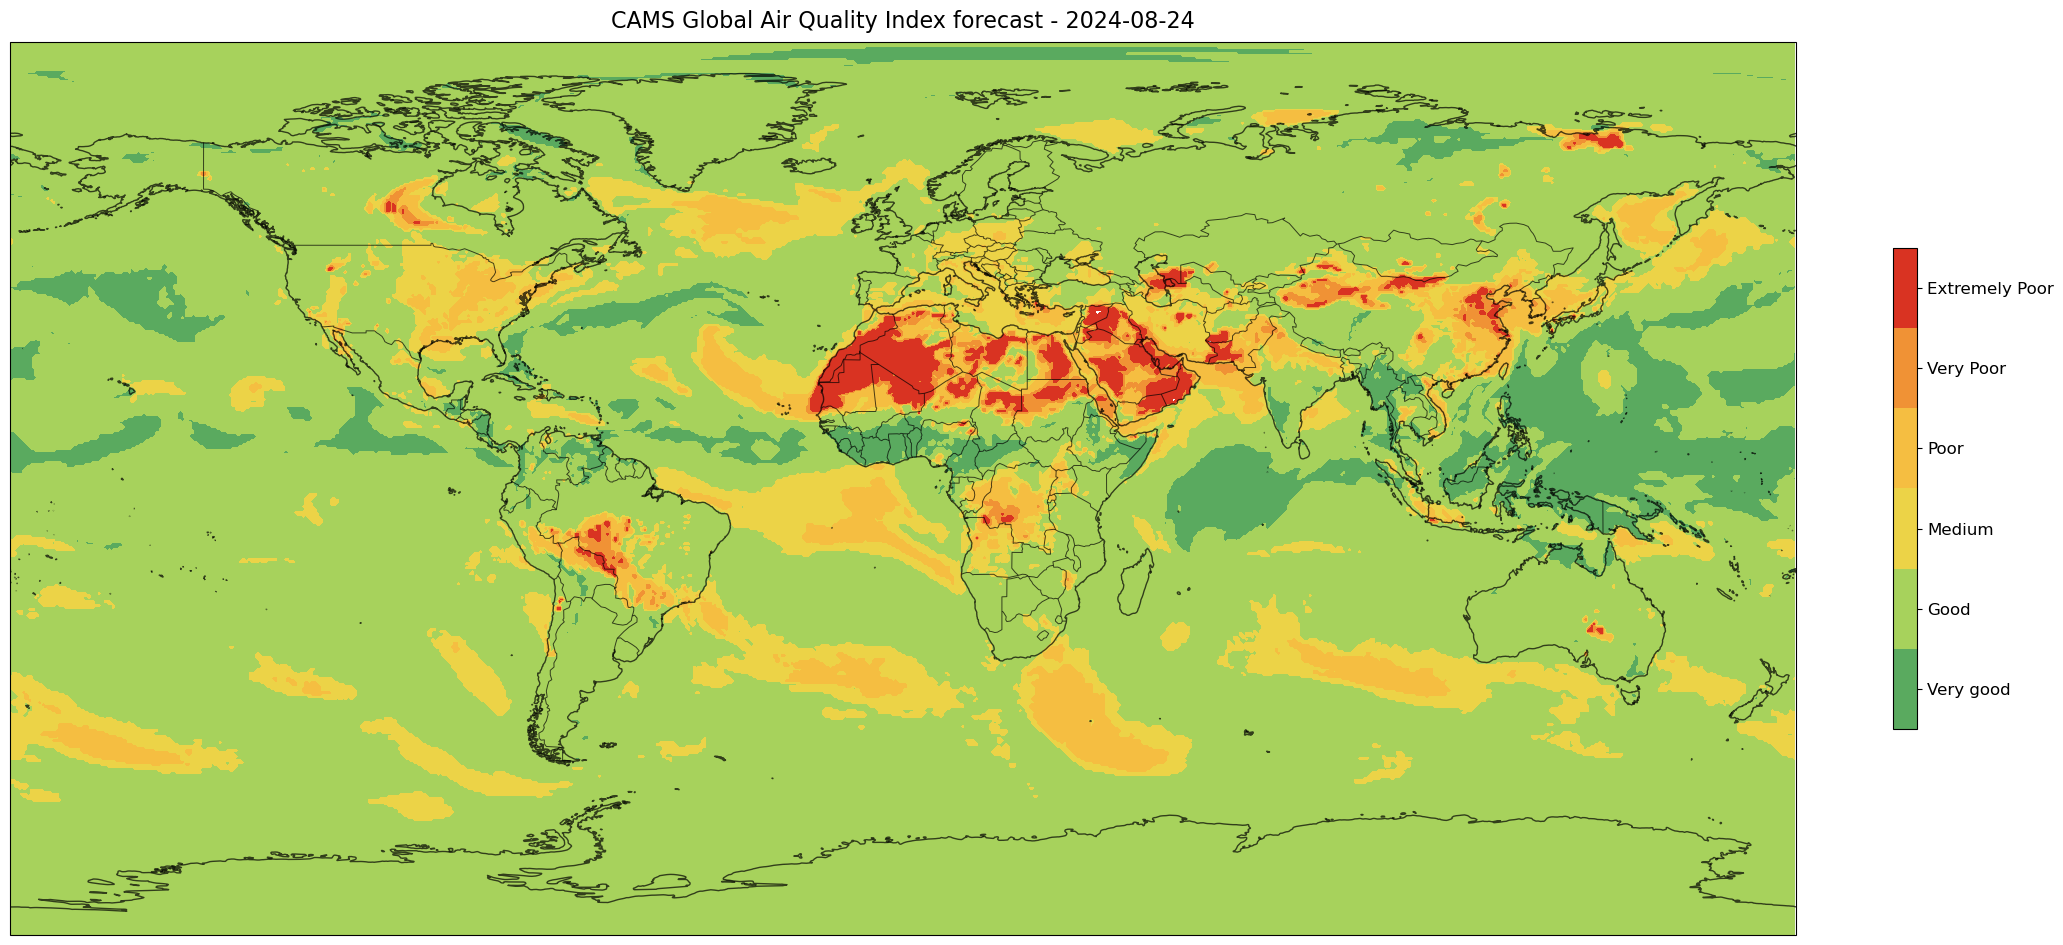

In [284]:
number_of_forecasts = 1
fig, ax = plt.subplots(
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(25, 25))

#for i in range(number_of_forecasts):
data = final_index[0]
timestamp = final_index.time
day = str(timestamp.values[i])[:10]
hour = str(timestamp.values[i])[11:16]
cs=ax.contourf(final_index.longitude, 
                       final_index.latitude, 
                       data,
                       levels=levels, 
                       #vmin=1, 
                       #vmax=6, 
                       cmap=aqi_cmap,
                       transform=ccrs.PlateCarree())
    
ax.set_title('CAMS Global Air Quality Index forecast - ' + day, fontsize=16, pad=10.0)
ax.coastlines(color='black', alpha=0.7, resolution='50m')
ax.add_feature(cfeature.BORDERS, alpha=0.7, linewidth=0.7)
ax.set_extent([bb_west, bb_east, bb_south, bb_north], crs=ccrs.PlateCarree())
    
# Customize colorbar
cbar = plt.colorbar(cs, fraction=0.028, pad=0.05, shrink=0.25) 
cbar.set_label(None)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(level_ticks)
cbar.set_ticklabels(labels)

## References
* [Jacob - Introduction to Atmospheric Chemistry](https://acmg.seas.harvard.edu/education/introduction-atmospheric-chemistry)
* Wilks - Statistical Methods in Atmospheric Science, 2nd Edition